In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython import display

SEED = 1
torch.random.manual_seed(SEED)
np.random.seed(SEED)

# Atomic Experiments

## Node2Vec

In order to gain better insight on Node2Vec let's design an atomic experiment. 

Suppose that we have the following graph




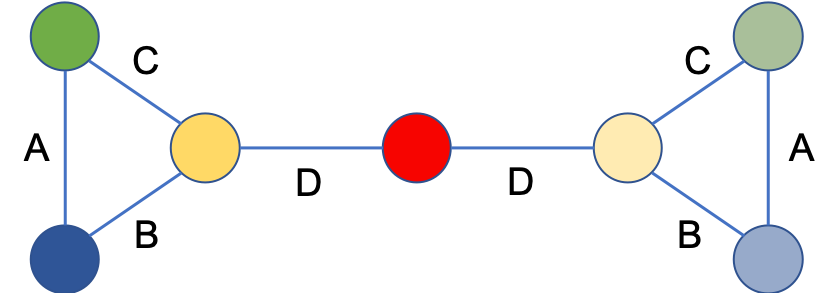

In [3]:
display.Image("../figures/graph.png")

and we would like to create the Node2Vec embedding. Try answering the following questions before running the code:

1. What is a good choice for the embedding dimension?
2. What do you expect to find in the vector representations?
3. How long do you expect this to take training? why?
4. What is a good window size?
5. How do you think the weights A, B, C, and D affect the results?

### A math question:

- How to transform weights into probabilities?

# Creating the embeddings

We need to do several things:

0. Imports, seeds
1. Create a way of representing the graph and the weights.
2. Create the random walks.
3. Use the word2vec embeddings. 

# 0. Preparations

We import the needed packages and set the random seeds.

## 1. Encoding the Graph

There are many ways of encoding a graph. We will use a simple way where we keep a dictionary of nodes to the nodes that it reaches and the weight.

In [4]:
# Yellow = Y
# Blue = B
# Green = G
# Red = R
# Soft Yellow = SY
# Soft Blue = SB
# Soft Green = SG
 
def create_graph(A=1, B=2, C=3, D=4):
    
    graph = {}
    graph["G"] = {"B": A, "Y": C}
    graph["B"] = {"G": A, "Y": B}
    graph["Y"] = {"B": B, "G": C, "R":D}
    
    graph["R"] = {"Y": D, "SY": D}
    
    graph["SG"] = {"SB": A, "SY": C}
    graph["SB"] = {"SG": A, "SY": B}
    graph["SY"] = {"SB": B, "SG": C, "R":D}
    
    return graph

In [5]:
graph = create_graph()

## 2. Creating the random walks

We need to create a large collection of walks. We will leave the number of steps and the number of samples as parameters.

In [6]:
# Returns what node to go next
def next_node(graph, node):
    
    # ===== Write your code here (HARD) ========
    neighbors = graph[node]
    
    n = []
    dist = []
    total = 0
    for key, val in neighbors.items():
        n.append(key)
        dist.append(val)
        total += val
    
    dist = [p/total for p in dist]
    # =========================================== 
    
    return np.random.choice(n,1,p=dist)[0]
    
# Returns a random walk starting from node as a list
def walk_from_node(graph, node, steps=5):
    
    walk = []
    
    # =========== Write your code here ===========
    for step in range(steps):
        walk.append(node)
        node = next_node(graph, node)
    # ===========================================    
    
    return walk

# Returns a list of lists each list a random walk. 
def create_random_walks(graph, steps=5, nb_samples=3):
    
    walks = []
    
    # =========== Write your code here ===========
    for _ in range(nb_samples):
        for node in ["G", "B", "Y", "R", "SG", "SB", "SY"]:
            walks.append(walk_from_node(graph, node, steps))
    # ===========================================        
    
    return walks

We can get some example with the next line

In [7]:
sentences = create_random_walks(graph, 10, 100)
sentences[:10]

[['G', 'Y', 'R', 'Y', 'G', 'B', 'G', 'B', 'Y', 'G'],
 ['B', 'Y', 'R', 'Y', 'R', 'Y', 'R', 'Y', 'R', 'Y'],
 ['Y', 'R', 'SY', 'SG', 'SY', 'R', 'SY', 'SB', 'SG', 'SB'],
 ['R', 'Y', 'G', 'Y', 'G', 'Y', 'G', 'Y', 'R', 'Y'],
 ['SG', 'SY', 'R', 'Y', 'R', 'Y', 'G', 'Y', 'G', 'Y'],
 ['SB', 'SG', 'SY', 'SB', 'SG', 'SY', 'SB', 'SY', 'SB', 'SY'],
 ['SY', 'SB', 'SY', 'R', 'Y', 'B', 'Y', 'R', 'SY', 'R'],
 ['G', 'Y', 'B', 'G', 'Y', 'G', 'B', 'Y', 'G', 'Y'],
 ['B', 'Y', 'R', 'SY', 'SG', 'SY', 'R', 'Y', 'R', 'SY'],
 ['Y', 'B', 'Y', 'G', 'Y', 'G', 'B', 'Y', 'R', 'Y']]

## 3. Creating the Embedings
Now that we have the "sentences" we need to transform them into numerical labels that represent the one-hot encoding.

In [8]:
node2idx = {"G": 0, "B": 1, "Y":2, "R":3, "SG":4, "SB":5, "SY":6}
idx2node = {0: "G", 1: "B", 2: "Y", 3: "R", 4: "SG", 5: "SB", 6: "SY"}

Next we create the skip-gram model. First the pairs

In [9]:
def create_pairs(sentence, window):
    
    assert window>0, "The window size should be greater than 0"
    pairs = []
    
    # =========== Write your code here ===========
    l = len(sentence)
    for i in range(l):
        for j in range(max(i-window,0), min(i+window+1, l)):
            if i!=j:
                pairs.append([sentence[i], sentence[j]])
    # ===========================================     
    
    return pairs

We can use this to generate our data

In [10]:
data = []
for sentence in sentences:
    data += create_pairs([node2idx[node] for node in sentence], 1)

In [11]:
data[:5]

[[0, 2], [2, 0], [2, 3], [3, 2], [3, 2]]

and then create our embeddings. 

In [12]:
emb_center = torch.nn.Embedding(7,3)
emb_context = torch.nn.Embedding(7,3)

We do the training in a particular way to introduce the concept of schedule learning rate. 

In [ ]:
losses = []

print("Using Learning rate of 0.1")
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= 0.1*param.grad
    for param in emb_context.parameters():
         param.data -= 0.1*param.grad

print("Using Learning rate of 0.01")
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= 0.01*param.grad
    for param in emb_context.parameters():
         param.data -= 0.01*param.grad

            
print("Using Learning rate of 0.001")
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= 0.001*param.grad
    for param in emb_context.parameters():
         param.data -= 0.001*param.grad

print("Using Learning rate of 0.00001")
for pair in data:
    a, b = pair
    emb_center.zero_grad()
    emb_context.zero_grad()
    a_against_all = torch.matmul(
        emb_context(torch.tensor([0, 1, 2, 3, 4, 5, 6])),
        emb_center(torch.tensor([a])).transpose(0,1))
    result = torch.nn.functional.log_softmax(a_against_all, dim=0)
    loss = torch.nn.functional.nll_loss(
        result.view(1, -1), torch.tensor([b]))
    loss.backward()

    # print(a,b,"\n",result, result[b])
    losses.append(loss.item())
    for param in emb_center.parameters():
         param.data -= 0.00001*param.grad
    for param in emb_context.parameters():
         param.data -= 0.00001*param.grad


Using Learning rate of 0.1
Using Learning rate of 0.01
Using Learning rate of 0.001
Using Learning rate of 0.00001


Let's take a look at the losses

In [ ]:
# Note: this code is not working properly
plt.plot(losses)
plt.show()

and the resulting probability distributions

In [ ]:
prob_dist = torch.nn.functional.softmax(
    torch.matmul( emb_context(torch.tensor([0,1,2,3,4,5,6])),
                 emb_center(torch.tensor([0,1,2,3,4,5,6])).transpose(0,1)),
    dim = 0)
(1000*prob_dist).round()/1000

and in order to run some experiments let's get the individual vector representations

In [ ]:
[G, B, Y, R, SG, SB, SY] = emb_center.weight
emb_center.weight

## Analogies

It is clear from the graph that there are cluster that are similar, we could think of them as analogies. We need something else first. 

### Finding the closest one

We need to a function to find the closest point (in cosine distance) to a given one

In [ ]:
def distance(a,b):
    
    # =========== Write your code here ===========
    d = 1-torch.mul(a,b).sum()/torch.sqrt(torch.mul(a,a).sum() * torch.mul(b,b).sum())
    # ============================================
    
    return d

def closest(a):
    
    mini = float("inf")
    mini_at = "Nah"
    
    # =========== Write your code here ===========
    for node, label in node2idx.items():
        if distance(a, emb_center.weight[label]) < mini:
            mini = distance(a, emb_center.weight[label])
            mini_at = node
    # ============================================
    
    return mini_at, mini

we can check that this is well defined if the following returns (Y,0)

In [ ]:
closest(Y)

### Some analogies

Let's see if we can get some analogies.

In [ ]:
closest(SB-B+G)

In [ ]:
closest(SG-G+B)

In [ ]:
closest(SY-Y+G)

# Some Remarks/Questions

## From counts to probability distributions

We can get the expected results by a simple count as we did in our previous experiment. Make sure that you understand how the following relates to the results


In [ ]:
counts = defaultdict(int)
for d in data:
    counts[tuple(d)]+=1
counts

## Embedding dimension 

The embedding dimension here is a tricky business. Try to use dim = 2 and see what happens? Can you get the analogy results? (Hard) Why do you think that happens? 

## Different seeds

What happens if we change the random seed to 13, or 42. Do we get the same results? what conclusions can you gather about this?

## Loss function

Look at the loss function. Make sure that you understand why the LR change creates a decrease in the loss. Can you ever get a loss of zero? why?